## Training/ Testing data

In [32]:
import numpy as np
import pandas as pd
from sklearn.cross_validation import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import RandomizedLogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from time import time
from operator import itemgetter
import time
from scipy import stats
from sklearn.metrics import confusion_matrix
import itertools
import brew
from brew.base import Ensemble
from brew.combination.combiner import Combiner
from brew.stacking.stacker import EnsembleStack
from brew.stacking.stacker import EnsembleStackClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_curve, auc

from sklearn.ensemble import RandomForestClassifier

from sklearn import (preprocessing, metrics, cross_validation)

from sklearn.externals import joblib


In [187]:
#upsample class 1

def upsample(data, labels):
    """
    This function is to upsample the data for the under-repressenting class with replacement. 
    The result will be a matrix with the same amount of species for each class.
    """
    
    from collections import defaultdict
    import random

    label_indices = defaultdict(lambda: list())
    for idx, label in enumerate(labels):
        label_indices[label].append(idx)

    largest_class_size = max(map(lambda l: len(l), label_indices.values()))

    upsampled_indices = []
    for label, indices in label_indices.items():
        sampled_indices = indices[:]
        while len(sampled_indices) < largest_class_size:
            sampled_indices.append(random.choice(indices))
        upsampled_indices.extend(sampled_indices)

    upsampled_labels = labels[upsampled_indices]
    upsampled_data = data[upsampled_indices, :]

    return upsampled_data, upsampled_labels

def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Input:
    target values 
    predicted values
    
    Returns
    optimal cutoff value
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



In [235]:
# divide into test set and training set

start = time.time()

datapath = 'H:/MatlabProjects/Nate/Dropbox/Rotation 3 Project/Data/FullData/featurematrixandtarget_02h'
datacontent = sio.loadmat(datapath)

X_tot = datacontent['featm']
X_tot = np.nan_to_num(X_tot) # replace nan with 0
nsubjects = X_tot.shape[0]
# X_tot = stats.zscore(X_tot)
# scaler = preprocessing.StandardScaler().fit(X_tot)
# X_tot = scaler.transform(X_tot)

Yv = datacontent['y']
Y_tot = np.ravel(Yv)

# datapath = 'D:/Dropbox (Nate)/Rotation 3 Project/Data/FullData_Agg/feature_05h.csv'
# datapath_y = 'D:/Dropbox (Nate)/Rotation 3 Project/Data/FullData_Agg/target_05h.csv'
# datapath= '/Users/ignacioperez-pozuelo/Dropbox/Rotation 3 Project/Data/FeatData/featurematrixandtarget_20h'
# X_tot = pd.read_csv(datapath)
# X_tot = np.nan_to_num(X_tot) # replace nan with 0

# Y_tot = pd.read_csv(datapath_y)
# Y_tot = np.ravel(Y_tot)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=None)
for train_index, test_index in sss.split(X_tot, Y_tot):
    X, X_test = X_tot[train_index], X_tot[test_index]
    Y, Y_test = Y_tot[train_index], Y_tot[test_index]
    
X,Y = upsample(X,Y)
X_test, Y_test = upsample(X_test, Y_test)
    


## Base classifier 1: Logistic Regression

In [238]:
start = time.time()

loo = LeaveOneOut()
fold = StratifiedKFold(Y, n_folds=10, shuffle=True, random_state=0)
SP = StratifiedShuffleSplit(n_splits=50, test_size=.2, random_state=0)

grid = {'C': np.power(10.0, np.linspace(-15, 15,100)), 'solver':['newton-cg','liblinear','lbfgs'],'class_weight':['balanced']}
#     score = None
# Using LogisticRegressionCV (cross validation search for Logistic regression) and report ROC_AUC score
clf = LogisticRegression(penalty='l2'
    ,random_state=0
    ,fit_intercept=True
    ,tol=.001)
searchCV = GridSearchCV(clf, grid, scoring='roc_auc', cv=SP, n_jobs = -1)

searchCV.fit(X, Y)

cvs_score = searchCV.cv_results_['mean_test_score'][searchCV.best_index_]
cvs_std = searchCV.cv_results_['std_test_score'][searchCV.best_index_]
param = searchCV.cv_results_['params'][searchCV.best_index_]

print(cvs_score,cvs_std)

end = time.time()
print (end - start)

grid_scores = searchCV.grid_scores_
top_scores_logistic = sorted(grid_scores,
                    key=itemgetter(1),
                    reverse=True)[:5]
for i, score in enumerate(top_scores_logistic):
    print("Model with rank: {0}".format(i + 1))
    print(("Mean validation score: "
           "{0:.3f} (std: {1:.3f})").format(
           score.mean_validation_score,
           np.std(score.cv_validation_scores)))
    print("Parameters: {0}".format(score.parameters))
    print("")
    


0.551 0.130648383075
24.311050176620483
Model with rank: 1
Mean validation score: 0.551 (std: 0.131)
Parameters: {'C': 0.043287612810830614, 'class_weight': 'balanced', 'solver': 'newton-cg'}

Model with rank: 2
Mean validation score: 0.550 (std: 0.131)
Parameters: {'C': 0.043287612810830614, 'class_weight': 'balanced', 'solver': 'lbfgs'}

Model with rank: 3
Mean validation score: 0.550 (std: 0.123)
Parameters: {'C': 0.043287612810830614, 'class_weight': 'balanced', 'solver': 'liblinear'}

Model with rank: 4
Mean validation score: 0.548 (std: 0.135)
Parameters: {'C': 0.021544346900318867, 'class_weight': 'balanced', 'solver': 'newton-cg'}

Model with rank: 5
Mean validation score: 0.548 (std: 0.135)
Parameters: {'C': 0.021544346900318867, 'class_weight': 'balanced', 'solver': 'lbfgs'}



C:\Users\hulabapp\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Area is 0.66


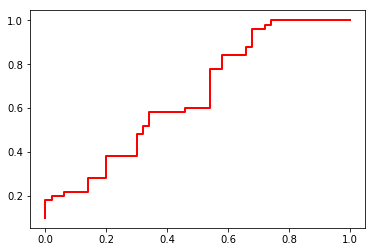

[0.43602041147164267]
[[28 22]
 [21 29]]


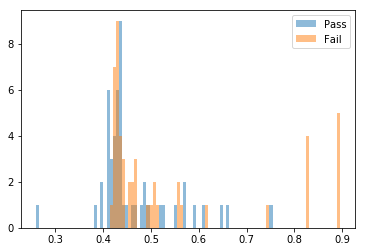

Area is 0.56


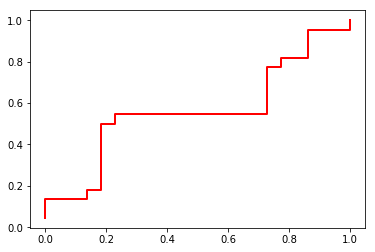

Confusion matrix, without normalization
[[15  7]
 [10 12]]


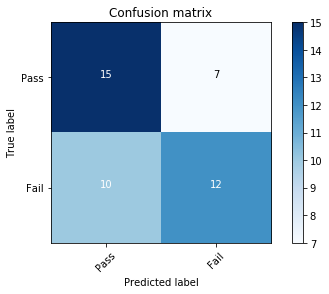

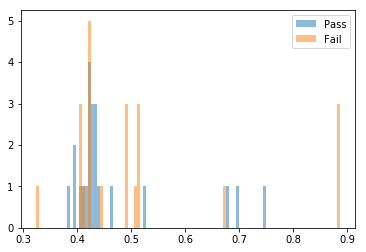

In [239]:
## Fit Training Data and Training Score

clf_sub = LogisticRegression(**top_scores_logistic[0].parameters,penalty='l2'
    ,random_state=0
    ,fit_intercept=True
    ,tol=.001)


Y_proba = clf_sub.fit(X,Y).predict_proba(X)
Y_pred = clf_sub.fit(X,Y).predict(X)
Y_df = clf_sub.fit(X,Y).decision_function(X)

roc_auc_score = []
# fpr, tpr, thresholds = roc_curve(Y, Y_df)
fpr, tpr, thresholds = roc_curve(Y, Y_proba[:,1])
roc_auc = auc(fpr, tpr)
roc_auc_score.append(roc_auc)
print('Area is %0.2f' %roc_auc)
plt.plot(fpr, tpr, lw=2, color='red')
plt.show() 

threshold = Find_Optimal_Cutoff(Y, Y_proba[:,1])
# threshold = .5
Y_predict = list(map(lambda x: 1 if x > threshold else 0, Y_proba[:,1]))
print (threshold)

print(confusion_matrix(Y, Y_predict))

## Create histogram of prediction
bins = np.linspace(min(Y_proba[:,1]), max(Y_proba[:,1]), 100)

plt.hist(Y_proba[:,1][Y==0], bins, alpha=0.5, label='Pass')
plt.hist(Y_proba[:,1][Y==1], bins, alpha=0.5, label='Fail')
plt.legend(loc='upper right')
plt.show()

## Resting Data

Y_proba = clf_sub.fit(X,Y).predict_proba(X_test)
Y_pred = clf_sub.fit(X,Y).predict(X_test)
Y_df = clf_sub.fit(X,Y).decision_function(X_test)

# threshold = Find_Optimal_Cutoff(Y, Y_proba[:,1])

Y_predict = list(map(lambda x: 1 if x > threshold else 0, Y_proba[:,1]))

# Print confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, Y_predict)

roc_auc_score = []
fpr, tpr, thresholds = roc_curve(Y_test, Y_df)
# fpr, tpr, thresholds = roc_curve(Y_test, Y_proba[:,1])
roc_auc = auc(fpr, tpr)
roc_auc_score.append(roc_auc)
print('Area is %0.2f' %roc_auc)
plt.plot(fpr, tpr, lw=2, color='red')
plt.show() 

cm = confusion_matrix(Y_test, Y_predict)
# Plot non-normalized confusion matrix
plot_confusion_matrix(cm, classes=['Pass', 'Fail'],
                      title='Confusion matrix')
plt.show()

## Histogram of testing data

bins = np.linspace(min(Y_proba[:,1]), max(Y_proba[:,1]), 100)

plt.hist(Y_proba[:,1][Y_test==0], bins, alpha=0.5, label='Pass')
plt.hist(Y_proba[:,1][Y_test==1], bins, alpha=0.5, label='Fail')
plt.legend(loc='upper right')
plt.show()


In [16]:
Y_predict


[0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1]

## Base classifier 2: Random Forest

In [240]:
start = time.time()

loo = LeaveOneOut()
fold = StratifiedKFold(Y, n_folds=10, shuffle=True, random_state=0)
SP = StratifiedShuffleSplit(n_splits=50, test_size=.2, random_state=0)

rs = {"n_estimators": [10, 50, 100, 300, 500],
              "max_depth": range(2,10),
              "max_features": [1, 2, 3, 4, 5, 6],
              "min_samples_split": range(2,10),
              "min_samples_leaf": range(2,10),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]} 

#     score = None
# Using LogisticRegressionCV (cross validation search for Logistic regression) and report ROC_AUC score
clf = RandomForestClassifier(class_weight = 'balanced')
searchCV = RandomizedSearchCV(clf, rs, n_iter=500, scoring='roc_auc', cv=SP, n_jobs=-1)

searchCV.fit(X, Y)

cvs_score = searchCV.cv_results_['mean_test_score'][searchCV.best_index_]
cvs_std = searchCV.cv_results_['std_test_score'][searchCV.best_index_]
param = searchCV.cv_results_['params'][searchCV.best_index_]

print(cvs_score,cvs_std)

end = time.time()
print (end - start)

grid_scores = searchCV.grid_scores_
top_scores_rf = sorted(grid_scores,
                    key=itemgetter(1),
                    reverse=True)[:5]
for i, score in enumerate(top_scores_rf):
    print("Model with rank: {0}".format(i + 1))
    print(("Mean validation score: "
           "{0:.3f} (std: {1:.3f})").format(
           score.mean_validation_score,
           np.std(score.cv_validation_scores)))
    print("Parameters: {0}".format(score.parameters))
    print("")
    



0.8263 0.09267583288
301.48098134994507
Model with rank: 1
Mean validation score: 0.826 (std: 0.093)
Parameters: {'n_estimators': 50, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 3, 'max_depth': 9, 'criterion': 'entropy', 'bootstrap': False}

Model with rank: 2
Mean validation score: 0.826 (std: 0.096)
Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 1, 'max_depth': 8, 'criterion': 'entropy', 'bootstrap': False}

Model with rank: 3
Mean validation score: 0.825 (std: 0.088)
Parameters: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 2, 'max_depth': 8, 'criterion': 'gini', 'bootstrap': False}

Model with rank: 4
Mean validation score: 0.824 (std: 0.092)
Parameters: {'n_estimators': 10, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 2, 'max_depth': 8, 'criterion': 'gini', 'bootstrap': False}

Model with rank: 5
Mean validation score: 0.823 (std: 0.094)
Parameters: {'n_est

C:\Users\hulabapp\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Area is 1.00


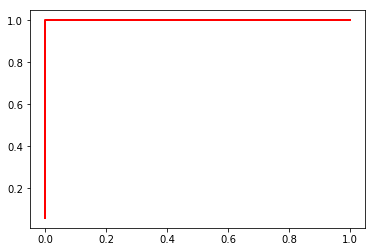

[0.61289828678946334]
[[50  0]
 [ 1 49]]


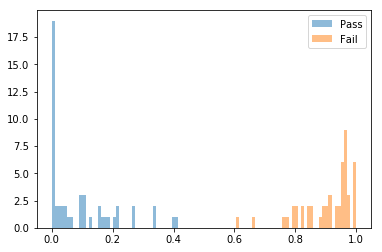

Area is 0.60


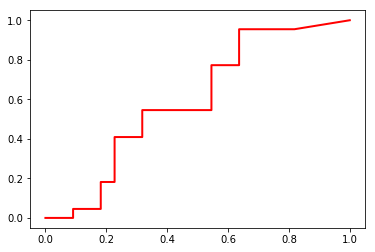

Confusion matrix, without normalization
[[19  3]
 [21  1]]


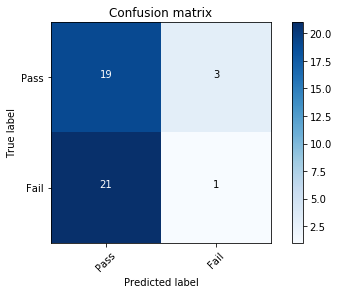

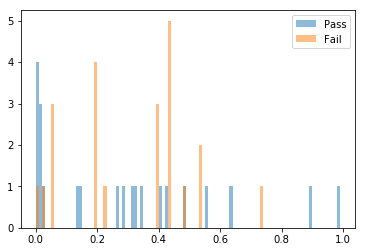

In [241]:
## Fit Training Data and Training Score

clf_sub = RandomForestClassifier(**top_scores_rf[0].parameters, class_weight = 'balanced')

Y_proba = clf_sub.fit(X,Y).predict_proba(X)
Y_pred = clf_sub.fit(X,Y).predict(X)
# Y_df = clf_sub.fit(X,Y).decision_function(X)

roc_auc_score = []
# fpr, tpr, thresholds = roc_curve(Y, Y_df)
fpr, tpr, thresholds = roc_curve(Y, Y_proba[:,1])
roc_auc = auc(fpr, tpr)
roc_auc_score.append(roc_auc)
print('Area is %0.2f' %roc_auc)
plt.plot(fpr, tpr, lw=2, color='red')
plt.show() 

threshold = Find_Optimal_Cutoff(Y, Y_proba[:,1])
# threshold = .5
Y_predict = list(map(lambda x: 1 if x > threshold else 0, Y_proba[:,1]))
print (threshold)

print(confusion_matrix(Y, Y_predict))

## Create histogram of prediction
bins = np.linspace(min(Y_proba[:,1]), max(Y_proba[:,1]), 100)

plt.hist(Y_proba[:,1][Y==0], bins, alpha=0.5, label='Pass')
plt.hist(Y_proba[:,1][Y==1], bins, alpha=0.5, label='Fail')
plt.legend(loc='upper right')
plt.show()

## Resting Data

Y_proba = clf_sub.fit(X,Y).predict_proba(X_test)
Y_pred = clf_sub.fit(X,Y).predict(X_test)
# Y_df = clf_sub.fit(X,Y).decision_function(X_test)

# threshold = Find_Optimal_Cutoff(Y, Y_proba[:,1])

Y_predict = list(map(lambda x: 1 if x > threshold else 0, Y_proba[:,1]))

# Print confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, Y_predict)

roc_auc_score = []
# fpr, tpr, thresholds = roc_curve(Y_test, Y_df)
fpr, tpr, thresholds = roc_curve(Y_test, Y_proba[:,1])
roc_auc = auc(fpr, tpr)
roc_auc_score.append(roc_auc)
print('Area is %0.2f' %roc_auc)
plt.plot(fpr, tpr, lw=2, color='red')
plt.show() 

cm = confusion_matrix(Y_test, Y_predict)
# Plot non-normalized confusion matrix
plot_confusion_matrix(cm, classes=['Pass', 'Fail'],
                      title='Confusion matrix')
plt.show()

## Histogram of testing data

bins = np.linspace(min(Y_proba[:,1]), max(Y_proba[:,1]), 100)

plt.hist(Y_proba[:,1][Y_test==0], bins, alpha=0.5, label='Pass')
plt.hist(Y_proba[:,1][Y_test==1], bins, alpha=0.5, label='Fail')
plt.legend(loc='upper right')
plt.show()

## SVC - rbf

In [205]:
start = time.time()

loo = LeaveOneOut()
fold = StratifiedKFold(Y, n_folds=10, shuffle=True, random_state=0)
SP = StratifiedShuffleSplit(n_splits=50, test_size=.2, random_state=0)

rs = {'gamma': np.logspace(-9, 3, 100), 'C': np.logspace(-2, 10, 100)} 

#     score = None
# Using LogisticRegressionCV (cross validation search for Logistic regression) and report ROC_AUC score
clf = SVC(class_weight = 'balanced')
searchCV = RandomizedSearchCV(clf, rs, n_iter=200, scoring='roc_auc', cv=SP, n_jobs=-1)

searchCV.fit(X, Y)

cvs_score = searchCV.cv_results_['mean_test_score'][searchCV.best_index_]
cvs_std = searchCV.cv_results_['std_test_score'][searchCV.best_index_]
param = searchCV.cv_results_['params'][searchCV.best_index_]

print(cvs_score,cvs_std)

end = time.time()
print (end - start)

grid_scores = searchCV.grid_scores_
top_scores_svc_rbf = sorted(grid_scores,
                    key=itemgetter(1),
                    reverse=True)[:5]
for i, score in enumerate(top_scores_svc_rbf):
    print("Model with rank: {0}".format(i + 1))
    print(("Mean validation score: "
           "{0:.3f} (std: {1:.3f})").format(
           score.mean_validation_score,
           np.std(score.cv_validation_scores)))
    print("Parameters: {0}".format(score.parameters))
    print("")
    



0.8923 0.0790013291027
125.66467237472534
Model with rank: 1
Mean validation score: 0.892 (std: 0.079)
Parameters: {'gamma': 26.56087782946684, 'C': 231.01297000831582}

Model with rank: 2
Mean validation score: 0.892 (std: 0.079)
Parameters: {'gamma': 26.56087782946684, 'C': 49770235.643321142}

Model with rank: 3
Mean validation score: 0.892 (std: 0.079)
Parameters: {'gamma': 26.56087782946684, 'C': 756463.32755462907}

Model with rank: 4
Mean validation score: 0.892 (std: 0.075)
Parameters: {'gamma': 327.45491628777319, 'C': 247707.63559917139}

Model with rank: 5
Mean validation score: 0.892 (std: 0.075)
Parameters: {'gamma': 327.45491628777319, 'C': 1232.8467394420659}



C:\Users\hulabapp\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Confusion matrix, without normalization
[[21  1]
 [22  0]]


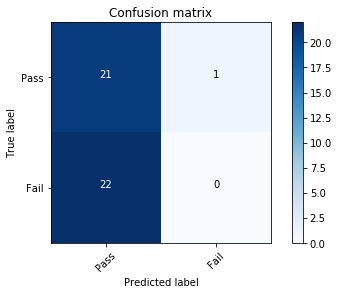

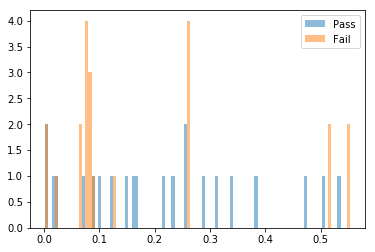

Accuracy Score 0.4773
Specificity Score 0.4773
Precision Score 0.0000
F1 Score 0.0000
Sensitivity Score 0.0000


In [206]:
## Fit Training Data and Training Score

clf_sub = SVC(**top_scores_svc_rbf[0].parameters, class_weight = 'balanced')

# Y_proba = clf_sub.fit(X,Y).predict_proba(X)
# Y_pred = clf_sub.fit(X,Y).predict(X)
# Y_df = clf_sub.fit(X,Y).decision_function(X)

# roc_auc_score = []
# # fpr, tpr, thresholds = roc_curve(Y, Y_df)
# fpr, tpr, thresholds = roc_curve(Y, Y_proba[:,1])
# roc_auc = auc(fpr, tpr)
# roc_auc_score.append(roc_auc)
# print('Area is %0.2f' %roc_auc)
# plt.plot(fpr, tpr, lw=2, color='red')
# plt.show() 

# # threshold = Find_Optimal_Cutoff(Y, Y_proba[:,1])
# # threshold = .1
# Y_predict = list(map(lambda x: 1 if x > threshold else 0, Y_proba[:,1]))
# print (threshold)

# print(confusion_matrix(Y, Y_predict))

# ## Create histogram of prediction
# bins = np.linspace(min(Y_proba[:,1]), max(Y_proba[:,1]), 100)

# plt.hist(Y_proba[:,1][Y==0], bins, alpha=0.5, label='Pass')
# plt.hist(Y_proba[:,1][Y==1], bins, alpha=0.5, label='Fail')
# plt.legend(loc='upper right')
# plt.show()

# ## Testing Data

# Y_proba = clf_sub.fit(X,Y).predict_proba(X_test)
Y_predict = clf_sub.fit(X,Y).predict(X_test)
# Y_df = clf_sub.fit(X,Y).decision_function(X_test)

# # threshold = Find_Optimal_Cutoff(Y, Y_proba[:,1])

# Y_predict = list(map(lambda x: 1 if x > threshold else 0, Y_proba[:,1]))

# Print confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, Y_predict)

# roc_auc_score = []
# # fpr, tpr, thresholds = roc_curve(Y_test, Y_df)
# fpr, tpr, thresholds = roc_curve(Y_test, Y_proba[:,1])
# roc_auc = auc(fpr, tpr)
# roc_auc_score.append(roc_auc)
# print('Area is %0.2f' %roc_auc)
# plt.plot(fpr, tpr, lw=2, color='red')
# plt.show() 

cm = confusion_matrix(Y_test, Y_predict)
# Plot non-normalized confusion matrix
plot_confusion_matrix(cm, classes=['Pass', 'Fail'],
                      title='Confusion matrix')
plt.show()

## Histogram of testing data

bins = np.linspace(min(Y_proba[:,1]), max(Y_proba[:,1]), 100)

plt.hist(Y_proba[:,1][Y_test==0], bins, alpha=0.5, label='Pass')
plt.hist(Y_proba[:,1][Y_test==1], bins, alpha=0.5, label='Fail')
plt.legend(loc='upper right')
plt.show()

from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
print('Accuracy Score %0.4f' %accuracy_score(Y_test,Y_predict))
from imblearn.metrics import sensitivity_specificity_support
print('Specificity Score %0.4f'%(sensitivity_specificity_support(Y_test, Y_predict, average = 'macro')[1]))
print('Precision Score %0.4f' %precision_score(Y_test, Y_predict))
print('F1 Score %0.4f' %f1_score(Y_test, Y_predict))
print('Sensitivity Score %0.4f' %recall_score(Y_test, Y_predict))

In [25]:
Y_predict

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0]

## k-nearest neighbor

In [153]:
start = time.time()

loo = LeaveOneOut()
fold = StratifiedKFold(Y, n_folds=10, shuffle=True, random_state=0)
SP = StratifiedShuffleSplit(n_splits=50, test_size=.2, random_state=0)

rs = {'n_neighbors': np.arange(5,20)+1, 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'leaf_size': np.arange(100)+1}

#     score = None
# Using LogisticRegressionCV (cross validation search for Logistic regression) and report ROC_AUC score
clf = KNeighborsClassifier()
searchCV = RandomizedSearchCV(clf, rs, n_iter=200, scoring='roc_auc', cv=SP, n_jobs=-1)

searchCV.fit(X, Y)

cvs_score = searchCV.cv_results_['mean_test_score'][searchCV.best_index_]
cvs_std = searchCV.cv_results_['std_test_score'][searchCV.best_index_]
param = searchCV.cv_results_['params'][searchCV.best_index_]

print(cvs_score,cvs_std)

end = time.time()
print (end - start)

grid_scores = searchCV.grid_scores_
top_scores_knn = sorted(grid_scores,
                    key=itemgetter(1),
                    reverse=True)[:5]
for i, score in enumerate(top_scores_knn):
    print("Model with rank: {0}".format(i + 1))
    print(("Mean validation score: "
           "{0:.3f} (std: {1:.3f})").format(
           score.mean_validation_score,
           np.std(score.cv_validation_scores)))
    print("Parameters: {0}".format(score.parameters))
    print("")
    

0.7113 0.117323527052
50.14182925224304
Model with rank: 1
Mean validation score: 0.711 (std: 0.117)
Parameters: {'n_neighbors': 6, 'leaf_size': 59, 'algorithm': 'kd_tree'}

Model with rank: 2
Mean validation score: 0.711 (std: 0.117)
Parameters: {'n_neighbors': 6, 'leaf_size': 31, 'algorithm': 'brute'}

Model with rank: 3
Mean validation score: 0.711 (std: 0.117)
Parameters: {'n_neighbors': 6, 'leaf_size': 7, 'algorithm': 'ball_tree'}

Model with rank: 4
Mean validation score: 0.711 (std: 0.117)
Parameters: {'n_neighbors': 6, 'leaf_size': 39, 'algorithm': 'kd_tree'}

Model with rank: 5
Mean validation score: 0.711 (std: 0.117)
Parameters: {'n_neighbors': 6, 'leaf_size': 1, 'algorithm': 'kd_tree'}



C:\Users\hulabapp\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Area is 1.00


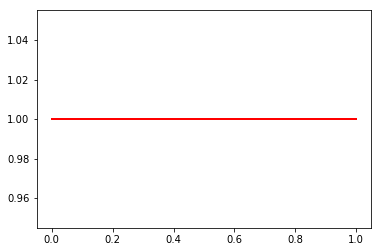

0.5
[[49  0]
 [ 0 49]]


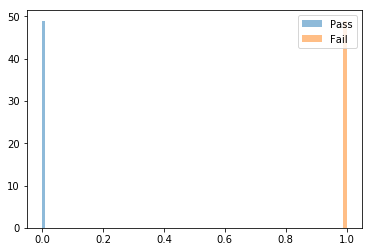

Area is 0.61


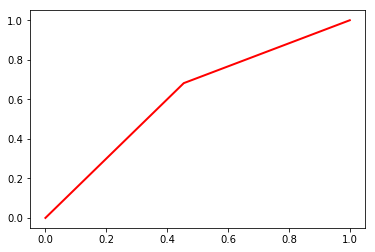

Confusion matrix, without normalization
[[12 10]
 [ 7 15]]


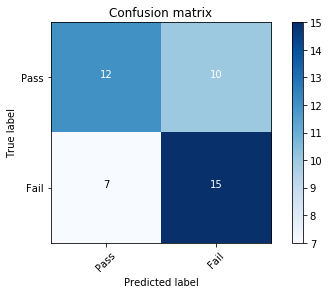

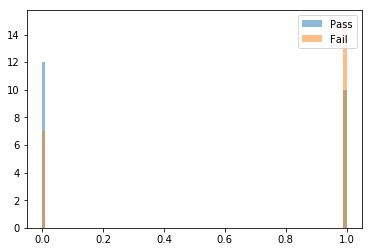

In [81]:
## Fit Training Data and Training Score

clf_sub = KNeighborsClassifier(**top_scores_knn[0].parameters)

Y_proba = clf_sub.fit(X,Y).predict_proba(X)
Y_pred = clf_sub.fit(X,Y).predict(X)
# Y_df = clf_sub.fit(X,Y).decision_function(X)

roc_auc_score = []
# fpr, tpr, thresholds = roc_curve(Y, Y_df)
fpr, tpr, thresholds = roc_curve(Y, Y_proba[:,1])
roc_auc = auc(fpr, tpr)
roc_auc_score.append(roc_auc)
print('Area is %0.2f' %roc_auc)
plt.plot(fpr, tpr, lw=2, color='red')
plt.show() 

# threshold = Find_Optimal_Cutoff(Y, Y_proba[:,1])
threshold = .5
Y_predict = list(map(lambda x: 1 if x > threshold else 0, Y_proba[:,1]))
print (threshold)

print(confusion_matrix(Y, Y_predict))

## Create histogram of prediction
bins = np.linspace(min(Y_proba[:,1]), max(Y_proba[:,1]), 100)

plt.hist(Y_proba[:,1][Y==0], bins, alpha=0.5, label='Pass')
plt.hist(Y_proba[:,1][Y==1], bins, alpha=0.5, label='Fail')
plt.legend(loc='upper right')
plt.show()

## Resting Data

Y_proba = clf_sub.fit(X,Y).predict_proba(X_test)
Y_pred = clf_sub.fit(X,Y).predict(X_test)
# Y_df = clf_sub.fit(X,Y).decision_function(X_test)

# threshold = Find_Optimal_Cutoff(Y, Y_proba[:,1])

Y_predict = list(map(lambda x: 1 if x > threshold else 0, Y_proba[:,1]))

# Print confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, Y_predict)

roc_auc_score = []
# fpr, tpr, thresholds = roc_curve(Y_test, Y_df)
fpr, tpr, thresholds = roc_curve(Y_test, Y_proba[:,1])
roc_auc = auc(fpr, tpr)
roc_auc_score.append(roc_auc)
print('Area is %0.2f' %roc_auc)
plt.plot(fpr, tpr, lw=2, color='red')
plt.show() 

cm = confusion_matrix(Y_test, Y_predict)
# Plot non-normalized confusion matrix
plot_confusion_matrix(cm, classes=['Pass', 'Fail'],
                      title='Confusion matrix')
plt.show()

## Histogram of testing data

bins = np.linspace(min(Y_proba[:,1]), max(Y_proba[:,1]), 100)

plt.hist(Y_proba[:,1][Y_test==0], bins, alpha=0.5, label='Pass')
plt.hist(Y_proba[:,1][Y_test==1], bins, alpha=0.5, label='Fail')
plt.legend(loc='upper right')
plt.show()

## Logistic Stacking

In [368]:
skf = list(StratifiedKFold(Y, n_folds = 10))

# clfs = [RandomForestClassifier(**{'n_estimators': 100, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 2, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': False}),
#         RandomForestClassifier(**{'n_estimators': 50, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 1, 'max_depth': 8, 'criterion': 'gini', 'bootstrap': False}),
#         RandomForestClassifier(**{'n_estimators': 10, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 1, 'max_depth': 4, 'criterion': 'entropy', 'bootstrap': False}),
#         RandomForestClassifier(**{'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 2, 'max_depth': 8, 'criterion': 'gini', 'bootstrap': False}),
#         RandomForestClassifier(**{'n_estimators': 500, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 1, 'max_depth': 4, 'criterion': 'entropy', 'bootstrap': True}),
#         LogisticRegression(**top_scores[0].parameters,penalty='l2',random_state=0,fit_intercept=True,tol=.005),
#         LogisticRegression(**top_scores[1].parameters,penalty='l2',random_state=0,fit_intercept=True,tol=.005),
#         LogisticRegression(**top_scores[2].parameters,penalty='l2',random_state=0,fit_intercept=True,tol=.005),
#         LogisticRegression(**top_scores[3].parameters,penalty='l2',random_state=0,fit_intercept=True,tol=.005),
#         LogisticRegression(**top_scores[4].parameters,penalty='l2',random_state=0,fit_intercept=True,tol=.005)]

clfs = [LogisticRegression(**top_scores[0].parameters,penalty='l2',random_state=0,fit_intercept=True,tol=.005),
        LogisticRegression(**top_scores[1].parameters,penalty='l2',random_state=0,fit_intercept=True,tol=.005),
        LogisticRegression(**top_scores[2].parameters,penalty='l2',random_state=0,fit_intercept=True,tol=.005),
        LogisticRegression(**top_scores[3].parameters,penalty='l2',random_state=0,fit_intercept=True,tol=.005),
        LogisticRegression(**top_scores[4].parameters,penalty='l2',random_state=0,fit_intercept=True,tol=.005),]
#        LogisticRegression(**top_scores[5].parameters,penalty='l2',random_state=0,fit_intercept=True,tol=.005),
#        LogisticRegression(**top_scores[6].parameters,penalty='l2',random_state=0,fit_intercept=True,tol=.005),
#        LogisticRegression(**top_scores[7].parameters,penalty='l2',random_state=0,fit_intercept=True,tol=.005),
#        LogisticRegression(**top_scores[8].parameters,penalty='l2',random_state=0,fit_intercept=True,tol=.005),
#        LogisticRegression(**top_scores[9].parameters,penalty='l2',random_state=0,fit_intercept=True,tol=.005)]

print ("Creating train and test sets for blending.")

dataset_blend_train = np.zeros((X.shape[0], len(clfs)))
dataset_blend_test = np.zeros((X_test.shape[0], len(clfs)))

for j, clf in enumerate(clfs):
    dataset_blend_test_j = np.zeros((X_test.shape[0], len(skf)))
    for i, (train, test) in enumerate(skf):
        X_tr = X[train]
        y_tr = Y[train]
        X_te = X[test]
        y_te = Y[test]
        clf.fit(X_tr, y_tr)
        y_submission = clf.predict_proba(X_te)[:, 1]
        dataset_blend_train[test, j] = y_submission
        dataset_blend_test_j[:, i] = clf.predict_proba(X_test)[:, 1]
    dataset_blend_test[:, j] = dataset_blend_test_j.mean(1)

clf = LogisticRegression()
clf.fit(dataset_blend_train, Y)
y_sub = clf.predict_proba(dataset_blend_train)[:,1]
y_submission = clf.predict_proba(dataset_blend_test)[:, 1]



Creating train and test sets for blending.


Area is 0.60


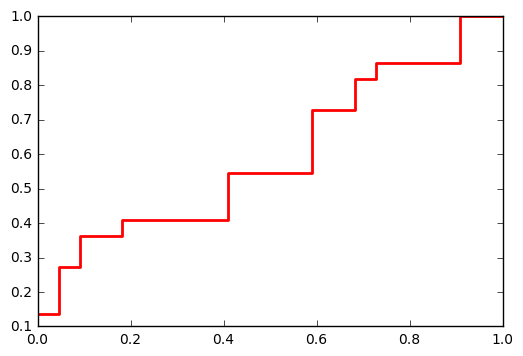

Confusion matrix, without normalization
[[12 10]
 [10 12]]


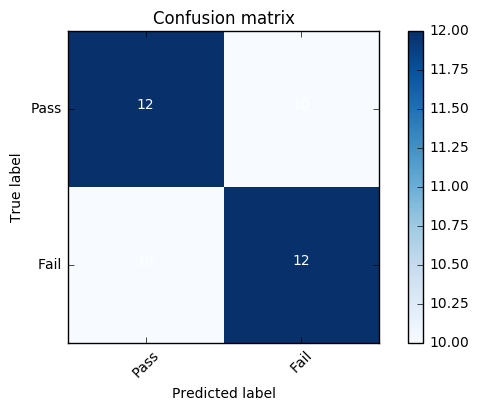

In [369]:
roc_auc_score = []
fpr, tpr, thresholds = roc_curve(Y_test, y_submission)
# fpr, tpr, thresholds = roc_curve(Y_test, Y_proba[:,1])
roc_auc = auc(fpr, tpr)
roc_auc_score.append(roc_auc)
print('Area is %0.2f' %roc_auc)
plt.plot(fpr, tpr, lw=2, color='red')
plt.show() 

# threshold = Find_Optimal_Cutoff(Y, y_sub)
threshold = .5

Y_predict = list(map(lambda x: 1 if x > threshold else 0, y_submission))

labels = ['pass', 'fail']


cm = confusion_matrix(Y_test, Y_predict)
# Plot non-normalized confusion matrix
plot_confusion_matrix(cm, classes=['Pass', 'Fail'],
                      title='Confusion matrix')
plt.show()
# print(Y_test.shape, y_submission.shape)

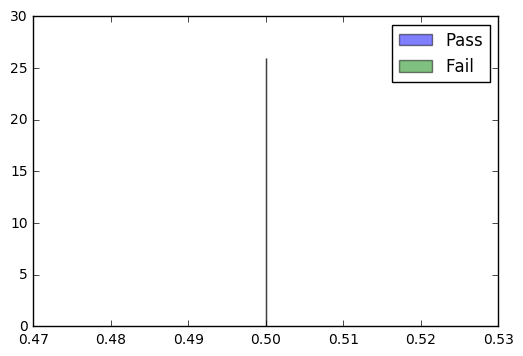

In [264]:
bins = np.linspace(min(y_submission), max(y_submission), 100)

plt.hist(y_submission[Y_test==0], bins, alpha=0.5, label='Pass')
plt.hist(y_submission[Y_test==1], bins, alpha=0.5, label='Fail')
plt.legend(loc='upper right')
plt.show()

## Mean Stacking

In [370]:
layer_1 = [LogisticRegression(**top_scores[0].parameters,penalty='l2',random_state=0,fit_intercept=True,tol=.005),
        LogisticRegression(**top_scores[1].parameters,penalty='l2',random_state=0,fit_intercept=True,tol=.005),
        LogisticRegression(**top_scores[2].parameters,penalty='l2',random_state=0,fit_intercept=True,tol=.005),
        LogisticRegression(**top_scores[3].parameters,penalty='l2',random_state=0,fit_intercept=True,tol=.005),
        LogisticRegression(**top_scores[4].parameters,penalty='l2',random_state=0,fit_intercept=True,tol=.005)]
 
layer_2 = [SVC(probability=True), LogisticRegression(max_iter=500)]
 
stack = EnsembleStack(cv=10) # number of folds per layer
stack.add_layer(Ensemble(layer_1))
stack.add_layer(Ensemble(layer_2))
 
clf = EnsembleStackClassifier(stack, Combiner('mean'))

# Train ensemble model on data and test 

clf.fit(X, Y)
y_stack_train = clf.predict_proba(X)[:,1]
y_stack_test = clf.predict_proba(X_test)[:,1]

Area is 0.60


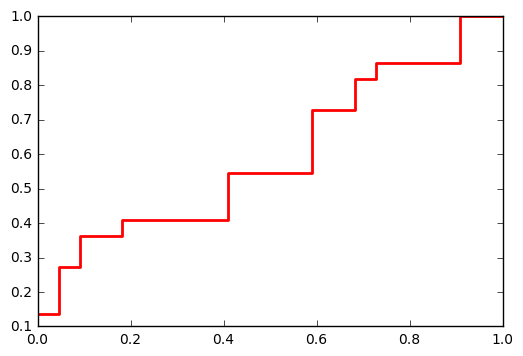

Confusion matrix, without normalization
[[13  9]
 [10 12]]


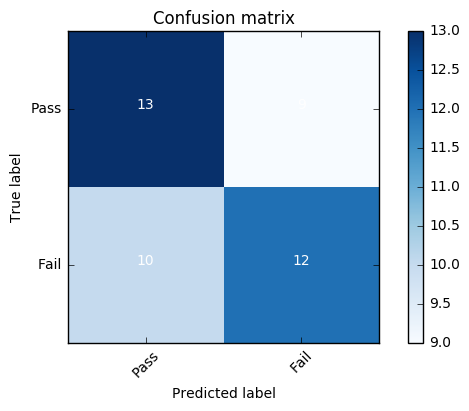

In [372]:
roc_auc_score = []
fpr, tpr, thresholds = roc_curve(Y_test, y_stack_test)
# fpr, tpr, thresholds = roc_curve(Y_test, Y_proba[:,1])
roc_auc = auc(fpr, tpr)
roc_auc_score.append(roc_auc)
print('Area is %0.2f' %roc_auc)
plt.plot(fpr, tpr, lw=2, color='red')
plt.show() 

# threshold = Find_Optimal_Cutoff(Y, y_stack_train)
threshold = .5

Y_predict = list(map(lambda x: 1 if x > threshold else 0, y_stack_test))

labels = ['pass', 'fail']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(Y_test, Y_predict)
# Plot non-normalized confusion matrix
plot_confusion_matrix(cm, classes=['Pass', 'Fail'],
                      title='Confusion matrix')
plt.show()
# print(Y_test.shape, y_submission.shape)

## Boosting Classifier Logistic

In [242]:
clf = AdaBoostClassifier(LogisticRegression(**top_scores_logistic[0].parameters,penalty='l2',random_state=0,fit_intercept=True,tol=.005), algorithm="SAMME", n_estimators=200)
# scores = cross_val_score(clf, X, Y)
clf.fit(X, Y)
y_boost_train = clf.predict_proba(X)[:,1]
y_boost_test = clf.predict_proba(X_test)[:,1]

roc_auc_score = []
fpr, tpr, thresholds = roc_curve(Y_test, y_boost_test)
# fpr, tpr, thresholds = roc_curve(Y_test, Y_proba[:,1])
roc_auc = auc(fpr, tpr)
roc_auc_score.append(roc_auc)
print('Area is %0.2f' %roc_auc)
plt.plot(fpr, tpr, lw=2, color='red')
plt.show() 

threshold = Find_Optimal_Cutoff(Y, y_boost_train)
# threshold = .5

Y_predict = list(map(lambda x: 1 if x > threshold else 0, y_boost_test))

labels = ['pass', 'fail']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(Y_test, Y_predict)
# Plot non-normalized confusion matrix
plot_confusion_matrix(cm, classes=['Pass', 'Fail'],
                      title='Confusion matrix')
plt.show()
# print(Y_test.shape, y_submission.shape)

ValueError: BaseClassifier in AdaBoostClassifier ensemble is worse than random, ensemble can not be fit.

## Boosting Classifier (RandomForest)

In [ ]:
clf = AdaBoostClassifier(RandomForestClassifier(**top_scores_rf[0].parameters, class_weight = 'balanced'), algorithm="SAMME", n_estimators=200)
# scores = cross_val_score(clf, X, Y)
clf.fit(X, Y)
y_boost_train = clf.predict_proba(X)[:,1]
y_boost_test = clf.predict_proba(X_test)[:,1]

roc_auc_score = []
fpr, tpr, thresholds = roc_curve(Y_test, y_boost_test)
# fpr, tpr, thresholds = roc_curve(Y_test, Y_proba[:,1])
roc_auc = auc(fpr, tpr)
roc_auc_score.append(roc_auc)
print('Area is %0.2f' %roc_auc)
plt.plot(fpr, tpr, lw=2, color='red')
plt.show() 

threshold = Find_Optimal_Cutoff(Y, y_boost_train)
# threshold = .5

Y_predict = list(map(lambda x: 1 if x > threshold else 0, y_boost_test))

labels = ['pass', 'fail']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(Y_test, Y_predict)
# Plot non-normalized confusion matrix
plot_confusion_matrix(cm, classes=['Pass', 'Fail'],
                      title='Confusion matrix')
plt.show()
# print(Y_test.shape, y_submission.shape)

In [88]:
clf4

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.005,
          verbose=0, warm_start=False), RandomForestClassifier... n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)],
          learning_rate=1.0, n_estimators=200, random_state=None)

Area is 0.78


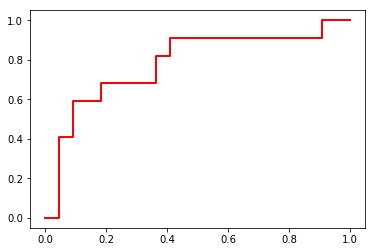

Confusion matrix, without normalization
[[20  2]
 [ 9 13]]


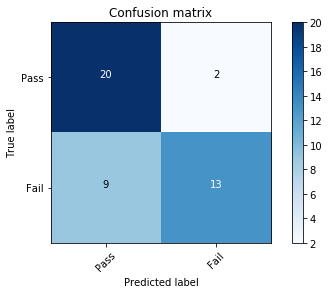

In [146]:
clf0 = LogisticRegression(**top_scores_logistic[0].parameters,penalty='l2'
    ,random_state=0
    ,fit_intercept=True
    ,tol=.001)
clf1 = LogisticRegression(**top_scores_logistic[1].parameters,penalty='l2'
    ,random_state=0
    ,fit_intercept=True
    ,tol=.001)
clf2 = AdaBoostClassifier(LogisticRegression(**top_scores_logistic[0].parameters,penalty='l2',random_state=0,fit_intercept=True,tol=.005), algorithm="SAMME", n_estimators=200)
clf3 = AdaBoostClassifier(LogisticRegression(**top_scores_logistic[1].parameters,penalty='l2',random_state=0,fit_intercept=True,tol=.005), algorithm="SAMME", n_estimators=200)
clf4 = RandomForestClassifier(**top_scores_rf[0].parameters, class_weight = 'balanced')
clf5 = RandomForestClassifier(**top_scores_rf[1].parameters, class_weight = 'balanced')
clf6 = AdaBoostClassifier(RandomForestClassifier(**top_scores_rf[0].parameters, class_weight = 'balanced'), algorithm="SAMME", n_estimators=200)
clf7 = AdaBoostClassifier(RandomForestClassifier(**top_scores_rf[1].parameters, class_weight = 'balanced'), algorithm="SAMME", n_estimators=200)
clf8 = SVC(**top_scores_svc_rbf[0].parameters, class_weight = 'balanced')
clf9 = SVC(**top_scores_svc_rbf[1].parameters, class_weight = 'balanced')

layer_1 = [clf3,clf4,clf5]
 
layer_2 = [LogisticRegression()]
 
stack = EnsembleStack(cv=10) # number of folds per layer
stack.add_layer(Ensemble(layer_1))
stack.add_layer(Ensemble(layer_2))
 
clf = EnsembleStackClassifier(stack, Combiner('mean'))

# Train ensemble model on data and test 

clf.fit(X, Y)
y_stack_train = clf.predict_proba(X)[:,1]
y_stack_test = clf.predict_proba(X_test)[:,1]

roc_auc_score = []
fpr, tpr, thresholds = roc_curve(Y_test, y_stack_test)
# fpr, tpr, thresholds = roc_curve(Y_test, Y_proba[:,1])
roc_auc = auc(fpr, tpr)
roc_auc_score.append(roc_auc)
print('Area is %0.2f' %roc_auc)
plt.plot(fpr, tpr, lw=2, color='red')
plt.show() 

threshold = Find_Optimal_Cutoff(Y, y_stack_train)
# threshold = .5

Y_predict = list(map(lambda x: 1 if x > threshold else 0, y_stack_test))

labels = ['pass', 'fail']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(Y_test, Y_predict)
# Plot non-normalized confusion matrix
plot_confusion_matrix(cm, classes=['Pass', 'Fail'],
                      title='Confusion matrix')
plt.show()
# print(Y_test.shape, y_submission.shape)

## Bagging KNN

Area is 0.56


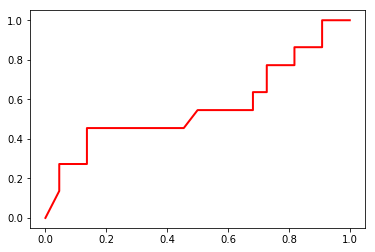

Confusion matrix, without normalization
[[13  9]
 [12 10]]


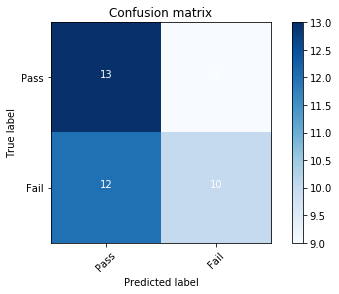

In [160]:
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(KNeighborsClassifier(**top_scores_knn[1].parameters),max_samples=0.8, max_features=0.5)
# scores = cross_val_score(clf, X, Y)
clf.fit(X, Y)
y_boost_train = clf.predict_proba(X)[:,1]
y_boost_test = clf.predict_proba(X_test)[:,1]

roc_auc_score = []
fpr, tpr, thresholds = roc_curve(Y_test, y_boost_test)
# fpr, tpr, thresholds = roc_curve(Y_test, Y_proba[:,1])
roc_auc = auc(fpr, tpr)
roc_auc_score.append(roc_auc)
print('Area is %0.2f' %roc_auc)
plt.plot(fpr, tpr, lw=2, color='red')
plt.show() 

threshold = Find_Optimal_Cutoff(Y, y_boost_train)
# threshold = .5

Y_predict = list(map(lambda x: 1 if x > threshold else 0, y_boost_test))

labels = ['pass', 'fail']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(Y_test, Y_predict)
# Plot non-normalized confusion matrix
plot_confusion_matrix(cm, classes=['Pass', 'Fail'],
                      title='Confusion matrix')
plt.show()
# print(Y_test.shape, y_submission.shape)

## High Level Stacking

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools

import sklearn

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from brew.base import Ensemble, EnsembleClassifier
from brew.stacking.stacker import EnsembleStack, EnsembleStackClassifier
from brew.combination.combiner import Combiner

clf0 = LogisticRegression(**top_scores_logistic[0].parameters,penalty='l2'
    ,random_state=0
    ,fit_intercept=True
    ,tol=.001)
clf1 = LogisticRegression(**top_scores_logistic[1].parameters,penalty='l2'
    ,random_state=0
    ,fit_intercept=True
    ,tol=.001)
clf2 = AdaBoostClassifier(LogisticRegression(**top_scores_logistic[0].parameters,penalty='l2',random_state=0,fit_intercept=True,tol=.005), algorithm="SAMME", n_estimators=200)
clf3 = AdaBoostClassifier(LogisticRegression(**top_scores_logistic[1].parameters,penalty='l2',random_state=0,fit_intercept=True,tol=.005), algorithm="SAMME", n_estimators=200)
clf4 = RandomForestClassifier(**top_scores_rf[0].parameters, class_weight = 'balanced')
clf5 = RandomForestClassifier(**top_scores_rf[1].parameters, class_weight = 'balanced')
clf6 = AdaBoostClassifier(RandomForestClassifier(**top_scores_rf[0].parameters, class_weight = 'balanced'), algorithm="SAMME", n_estimators=200)
clf7 = AdaBoostClassifier(RandomForestClassifier(**top_scores_rf[1].parameters, class_weight = 'balanced'), algorithm="SAMME", n_estimators=200)


# Initializing Classifiers
# clf1 = LogisticRegression(random_state=0)
# clf2 = RandomForestClassifier(random_state=0)
# clf3 = SVC(random_state=0, probability=True)

# Creating Ensemble
ensemble = Ensemble([clf0, clf2,clf4,clf6])
eclf = EnsembleClassifier(ensemble=ensemble, combiner=Combiner('mean'))

# Creating Stacking
layer_1 = Ensemble([clf0, clf2,clf4,clf6])
layer_2 = Ensemble([LogisticRegression()])

stack = EnsembleStack(cv=10)

stack.add_layer(layer_1)
stack.add_layer(layer_2)

sclf = EnsembleStackClassifier(stack)

clf_list = [clf0, clf1, clf2, clf3, clf4, clf5, clf6, clf7, eclf, sclf]
lbl_list = ['1','2','3','4','5','6','7','8', 'Ensemble', 'Stacking']

for clf, lab in zip(clf_list, lbl_list):
    clf.fit(X, Y)
    y_stack_train = clf.predict_proba(X)[:,1]
    y_stack_test = clf.predict_proba(X_test)[:,1]
    
    roc_auc_score = []
    fpr, tpr, thresholds = roc_curve(Y_test, y_stack_test)
    # fpr, tpr, thresholds = roc_curve(Y_test, Y_proba[:,1])
    roc_auc = auc(fpr, tpr)
    roc_auc_score.append(roc_auc)
    print(lab)
    print('Area is %0.2f' %roc_auc)
    plt.plot(fpr, tpr, lw=2, color='red')
    plt.show() 

    threshold = Find_Optimal_Cutoff(Y, y_stack_train)
#     threshold = .5

    Y_predict = list(map(lambda x: 1 if x > threshold else 0, y_stack_test))

    labels = ['pass', 'fail']

    cm = confusion_matrix(Y_test, Y_predict)
    # Plot non-normalized confusion matrix
    plot_confusion_matrix(cm, classes=['Pass', 'Fail'],
                          title='Confusion matrix')
    plt.show()
    # print(Y_test.shape, y_submission.shape)
    from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
    print('Accuracy Score %0.4f' %accuracy_score(Y_test,Y_predict))
    from imblearn.metrics import sensitivity_specificity_support
    print('Specificity Score %0.4f'%(sensitivity_specificity_support(Y_test, Y_predict, average = 'macro')[1]))
    print('Precision Score %0.4f' %precision_score(Y_test, Y_predict))
    print('F1 Score %0.4f' %f1_score(Y_test, Y_predict))
    print('Sensitivity Score %0.4f' %recall_score(Y_test, Y_predict))
    

In [145]:
sensitivity_specificity_support(Y_test, Y_predict, average = 'micro')[1]

0.70454545454545459